# Assignment 4

Deadline: 30.04.2025 12:00 CET

<Add your name, student-id and emal address>

## Prerequisites: Library imports, data load and initialization of the backtest service

In [78]:
# Standard library imports
import os
import sys
import copy
from typing import Optional

# Third party imports
import numpy as np
import pandas as pd

# Add the project root directory to Python path
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   #<Change this path if needed>
src_path = os.path.join(project_root, 'qpmwp-course\\src')    #<Change this path if needed>
sys.path.append(project_root)
sys.path.append(src_path)

# Local modules imports
from helper_functions import load_data_spi, load_pickle
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.optimization import Optimization, Objective, MeanVariance
from optimization.optimization_data import OptimizationData
from optimization.constraints import Constraints
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest

In [79]:
# ! pip install fastparquet
# ! pip install pyarrow

In [80]:
# Load data
path_to_data = 'C:/Valentino/UZH/Quant portfolio management with Python/qpmwp-course/data/'  # <change this to your path to data>

# Load market and jkp data from parquet files
market_data = pd.read_parquet(path = f'{path_to_data}market_data.parquet')

# Instantiate the BacktestData class
# and set the market data and jkp data as attributes
data = BacktestData()
data.market_data = market_data
data.bm_series = load_data_spi(path='C:/Valentino/UZH/Quant portfolio management with Python/qpmwp-course/data/')


In [81]:
# Define rebalancing dates
n_days = 21*3
market_data_dates = market_data.index.get_level_values('date').unique().sort_values(ascending=True)
rebdates = market_data_dates[market_data_dates > '2015-01-01'][::n_days].strftime('%Y-%m-%d').tolist()

In [82]:
# Define the selection item builders.
selection_item_builders = {
    'gaps': SelectionItemBuilder(
        bibfn = bibfn_selection_gaps,
        width = 252*3,
        n_days = 10,
    ),
    'min_volume': SelectionItemBuilder(
        bibfn = bibfn_selection_min_volume,
        width = 252,
        min_volume = 500_000,
        agg_fn = np.median,
    ),
}

# Define the optimization item builders.
optimization_item_builders = {
    'return_series': OptimizationItemBuilder(
        bibfn = bibfn_return_series,
        width = 252*3,
        fill_value = 0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn = bibfn_budget_constraint,
        budget = 1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn = bibfn_box_constraints,
        upper = 0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn = bibfn_size_dependent_upper_bounds,
        small_cap = {'threshold': 300_000_000, 'upper': 0.02},
        mid_cap = {'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap = {'threshold': 10_000_000_000, 'upper': 0.1},
    ),
}

# Initialize the backtest service
bs = BacktestService(
    data = data,
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

## 1. Maximum Sharpe Ratio Portfolio

a) 

(6 points)

Complete the `MaxSharpe` class below by implementing your its methods `set_objective` and `solve`.
The `solve` method should implement an iterative algorithm that quickly approximates the "true" maximimum Sharpe ratio portfolio (given the estimates of mean and covariance). This approximation should be done by repeatedly solving a mean-variance optimization problem, where the risk aversion parameter (which scales the covariance matrix) is adjusted in each iteration. The algorithm should terminate after a maximum of 10 iterations. 

In [83]:
class MaxSharpe(Optimization):

    def __init__(self,
                 constraints: Optional[Constraints] = None,
                 covariance: Optional[Covariance] = None,
                 expected_return: Optional[ExpectedReturn] = None,
                 **kwargs) -> None:
        super().__init__(
            constraints=constraints,
            **kwargs,
        )
        self.covariance = Covariance() if covariance is None else covariance
        self.expected_return = ExpectedReturn() if expected_return is None else expected_return
        self.turnover_penalty = kwargs.get('turnover_penalty', 0.0)
        self.optimization_data = None

    def set_objective(self, optimization_data: OptimizationData) -> None:
        self.optimization_data = optimization_data

        X = optimization_data['return_series']
        self.expected_return.estimate(X, inplace=True)
        self.covariance.estimate(X, inplace=True)

        mu = self.expected_return.vector
        Sigma = self.covariance.matrix

        risk_aversion = 1.0
        P = Sigma * risk_aversion
        q = -mu.to_numpy()

        self.objective = Objective(P=P, q=q)
        return None

    def solve(self) -> None:
        if self.optimization_data is None:
            raise ValueError("Missing optimization_data. Be sure to call set_objective() first.")

        mu = self.expected_return.vector
        Sigma = self.covariance.matrix

        w_prev = self.optimization_data.get('previous_weights', pd.Series(0, index=mu.index)).reindex(mu.index).fillna(0)

        best_sharpe = -np.inf
        best_weights = None

        for i in range(10):
            risk_aversion = 10 ** (-1 + i * 0.2)

            P = Sigma * risk_aversion
            q = -mu.to_numpy()
            self.objective = Objective(P=P, q=q)

            self.params['turnover_penalty'] = self.turnover_penalty
            self.params['x_init'] = w_prev.to_dict()

            try:
                self.model_qpsolvers()
                self.model.solve()  
                self.solve_qpsolvers()   
            except Exception:
                continue

            weights = pd.Series(self.results['weights'])
            port_return = np.dot(weights, mu)
            port_vol = np.sqrt(np.dot(weights, np.dot(Sigma, weights)))
            sharpe_ratio = port_return / port_vol if port_vol > 0 else -np.inf

            if sharpe_ratio > best_sharpe:
                best_sharpe = sharpe_ratio
                best_weights = weights

            w_prev = weights

        self.results['weights'] = best_weights.to_dict() if best_weights is not None else {}
        self.results['sharpe'] = best_sharpe
        return None


b) 

(2 points)

Provide a theoretical or empirical justification that your algorithm converges to the true maximum Sharpe ratio portfolio for the given coefficients of mean and covariance.
Hint: If you want to provide an empirical justification, you can perform an optimization for a single point in time by running the following code.

## Theoretical Justification:

The goal of the MaxSharpe algorithm is to find the portfolio weights **w** that maximize the Sharpe ratio:

$$
\max_{\mathbf{w}} \quad \frac{\mathbf{w}^\top \boldsymbol{\mu}}{\sqrt{\mathbf{w}^\top \Sigma \mathbf{w}}} \quad \text{s.t.} \quad \mathbf{w} \in \mathcal{W}
$$

where:
- $ \boldsymbol{\mu} $ is the expected return vector,
- $ \Sigma $ is the covariance matrix of returns,
- $ \mathcal{W} $ denotes the feasible set defined by constraints.

This optimization problem is **non-convex** due to the ratio of quadratic and linear terms. However, it can be efficiently approximated using a **sequence of mean-variance optimizations** with varying risk aversion levels:

$$
\min_{\mathbf{w}} \quad \mathbf{w}^\top \Sigma \mathbf{w} - \gamma \mathbf{w}^\top \boldsymbol{\mu}
$$

Each value of $ \gamma $ (risk aversion) defines a point on the **efficient frontier**. The Sharpe ratio of a portfolio is the slope of the line from the origin to that point. The **maximum Sharpe ratio portfolio lies at the tangency point** between the capital market line and the efficient frontier.

By solving the mean-variance problem for a range of $ \gamma $ values and selecting the portfolio with the highest Sharpe ratio, the algorithm converges (approximately) to the tangency portfolio. The finer and better targeted the grid of $ \gamma $, the closer the solution is to the true maximum Sharpe ratio.


In [84]:
# bs.optimization = MaxSharpe(
#     covariance=Covariance(method='pearson'),
#     expected_return=ExpectedReturn(method='geometric'),
#     solver_name='cvxopt',  # <change this to your preferred solver>
#     #<add any other parameters you need, e.g., number of iterations, tolerance, etc.>
# )
# bs.prepare_rebalancing('2015-01-02')
# bs.optimization.set_objective(bs.optimization_data)
# bs.optimization.solve()

## 2. Backtest MaxSharpe with Turnover Penalty

(5 points)

Calibrate the turnover penalty parameter such that the backtest of the MaxSharpe strategy displays an annual turnover of roughly 100%.

In [87]:
# Update the backtest service with a MaxSharpe optimization object
bs.optimization = MaxSharpe(
    covariance=Covariance(method='pearson'),
    expected_return=ExpectedReturn(method='geometric'),
    solver_name='cvxopt',    # <change this to your preferred solver>
    turnover_penalty=0.8,   # <change this>
)

# Instantiate the backtest object
bt_ms = Backtest()

# Run the backtest
bt_ms.run(bs = bs)


return_series = bs.data.get_return_series()
turnover_series = bt_ms.strategy.turnover(return_series)
annual_turnover = turnover_series.mean() * 4

print("Average Annual Turnover: {:.2f}%".format(annual_turnover * 100))

Rebalancing date: 2015-01-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-06-29
Rebalancing date: 2015-09-24
Rebalancing date: 2015-12-22
Rebalancing date: 2016-03-18
Rebalancing date: 2016-06-15
Rebalancing date: 2016-09-12
Rebalancing date: 2016-12-08
Rebalancing date: 2017-03-07
Rebalancing date: 2017-06-02
Rebalancing date: 2017-08-30
Rebalancing date: 2017-11-27
Rebalancing date: 2018-02-22
Rebalancing date: 2018-05-22
Rebalancing date: 2018-08-17
Rebalancing date: 2018-11-14
Rebalancing date: 2019-02-11
Rebalancing date: 2019-05-09
Rebalancing date: 2019-08-06
Rebalancing date: 2019-11-01
Rebalancing date: 2020-01-29
Rebalancing date: 2020-04-27
Rebalancing date: 2020-07-23
Rebalancing date: 2020-10-20
Rebalancing date: 2021-01-15
Rebalancing date: 2021-04-14
Rebalancing date: 2021-07-12
Rebalancing date: 2021-10-07
Rebalancing date: 2022-01-04
Rebalancing date: 2022-04-01
Rebalancing date: 2022-06-29
Rebalancing date: 2022-09-26
Rebalancing date: 2022-12-22
Rebalancing da

## 3. Simulation and Descriptive Statistics

(3 points)

- Simulate the portfolio returns from your MaxSharpe backtest. Use fixed costs of 1% and variable costs of 0.3%.
- Plot the cumulated returns of the MaxSharpe strategy together with those of the SPI Index.
- Plot the turnover of your MaxSharpe strategy over time.
- Print the annualized turnover (computed as the average turnover over the backtest multiplied by the number of rebalancing per year) for your MaxSharpe strategy.
- Create and print a table with descriptive performance statistics for your MaxSharpe strategy and the SPI Index.


c:\Valentino\UZH\Quant portfolio management with Python\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
c:\Valentino\UZH\Quant portfolio management with Python\qpmwp-course\src\backtesting\strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


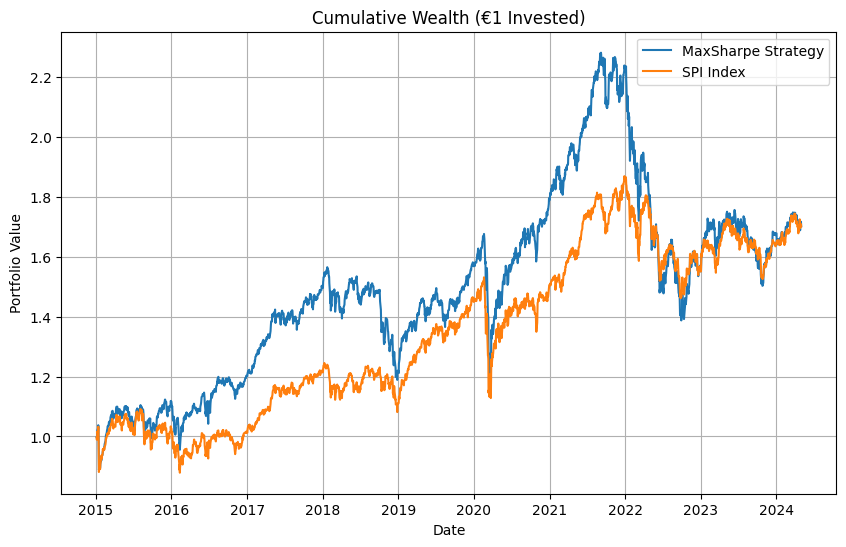

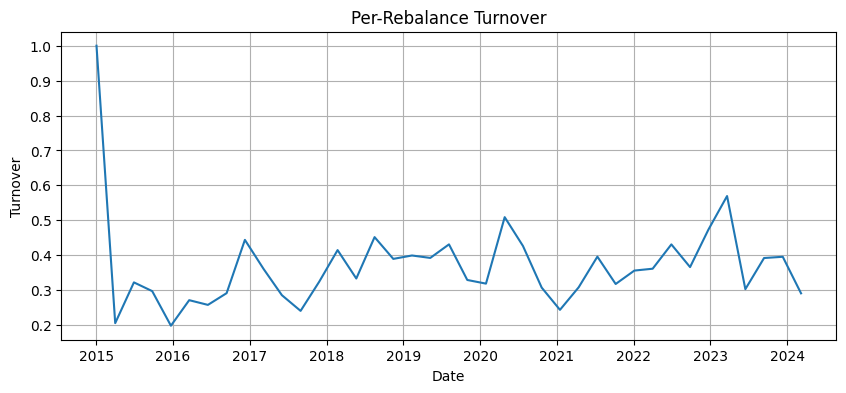

Average Annual Turnover: 147.64%

Descriptive Performance Statistics:
           Ann. Return  Ann. Volatility  Sharpe Ratio  Max Drawdown
MaxSharpe        5.67%           16.02%        35.36%       -39.18%
SPI              5.66%           14.57%        38.84%       -26.33%


In [88]:
import matplotlib.pyplot as plt

#costs
ret_series = bs.data.get_return_series()
sim_ret = bt_ms.strategy.simulate(
    return_series=ret_series,
    fc=0.01,  
    vc=0.003   
)

#benchmark
spi = bs.data.bm_series.reindex(sim_ret.index).fillna(0)
sim_df = pd.concat({
    'MaxSharpe': sim_ret,
    'SPI':        spi
}, axis=1)

#cumulative returns
cum = (1 + sim_df).cumprod()
plt.figure(figsize=(10, 6))
plt.plot(cum.index, cum['MaxSharpe'], label='MaxSharpe Strategy')
plt.plot(cum.index, cum['SPI'],        label='SPI Index')
plt.title('Cumulative Wealth (€1 Invested)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()

#turnover
turnover = bt_ms.strategy.turnover(ret_series)
turnover.index = pd.to_datetime(turnover.index)

plt.figure(figsize=(10, 4))
plt.plot(turnover.index, turnover)
plt.title('Per-Rebalance Turnover')
plt.xlabel('Date')
plt.ylabel('Turnover')
plt.grid(True)
plt.show()

#Annualized turnover
n_days = 21 * 3
rebalances_per_year = 252 / n_days
annual_turn = turnover.mean() * rebalances_per_year
print(f"Average Annual Turnover: {annual_turn:.2%}")

#Descriptive performance statistics
def performance_stats(returns, periods_per_year=252):
    ann_ret = (1 + returns).prod()**(periods_per_year / len(returns)) - 1
    ann_vol = returns.std() * np.sqrt(periods_per_year)
    sharpe  = ann_ret / ann_vol if ann_vol > 0 else np.nan
    wealth  = (1 + returns).cumprod()
    max_dd  = (wealth / wealth.cummax() - 1).min()
    return pd.Series({
        'Ann. Return':     ann_ret,
        'Ann. Volatility': ann_vol,
        'Sharpe Ratio':    sharpe,
        'Max Drawdown':    max_dd
    })

stats = sim_df.apply(performance_stats).T
print("\nDescriptive Performance Statistics:")
print(stats.to_string(float_format='{:,.2%}'.format))
